## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem #для локального Notebook: pip install pymystem3==0.1.10 
m = Mystem()
from collections import Counter

In [2]:
df = pd.read_csv('/datasets/data.csv')

#### Найденные ошибки в данных:
- в данных по количеству детей children есть маловероятные значения -1 и 20;
- в данных по трудовому стажу days_employed есть отрицательные значения, нереально большие величины, избыточные десятичные знаки, пропуски типа NaN;
- в данных по возрасту dob_years заемщика есть значения равные нулю;
- в данных по образованию education разное написание одно и того же вида образования;
- в данных пола клиента gender у индекса 10701 значение поля 'XNA';
- в данных о целях кредита необходима лемматизация;
- есть строки полные дубликаты.

### Шаг 2. Предобработка данных

In [3]:
# заменим отрицательные значения трудового стажа в положительные
df.loc[df['days_employed'] < 0, 'days_employed'] = -1 * df[df['days_employed'] < 0]

# переведем дни стажа в года
df['days_employed'] = df['days_employed'] / 365
df['days_employed'] = df['days_employed'].round(decimals=2)
df.columns = ['children', 'years_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose']

# приведем к единобразию категории образования
df['education'] = df['education'].str.lower()

# в данных по количеству детей children есть нереальные значения в -1 и 20 детей, 
# общее кол-во строк 76 относительно длины датафрейма 21525 составляет 0.4% => можно удалить
df = df[(df['children'] != -1) & (df['children'] != 20)]

In [4]:
# вынесем данные содержащие NaN в total_income в отдельный датафрейм
df_nan_only = df[df['total_income'].notna() == False]

# проверим как распределены пропуски в total_income для каждой категориям, здесь пример для children   
df_nan_only['children'].value_counts(normalize=True).round(2)

# соотнесем абсолютные значения children с общим количеством в исходном датафрейме 
# например, для заемщиков с количеством детей 0:
df_nan_only[df_nan_only['children'] == 0]['children'].count() / df[df['children'] == 0]['children'].count()

# для остальных категорий провяряем аналогичным образом 


0.10170330058661389

#### Вывод
- пропуски в столбце total_income занимают не более 11% в каждой категории children, education, family_status, gender, income_type;
- есть закономерность в расположении пропусков между days_employed и total_income, возможно, значения ежемесячного дохода являются усредненными и рассчитываются исходя из общего стажа. Тогда пропуски в данных по стажу дали пропуски в доходе.

### Обработка пропусков

In [5]:
# найдем пропуски и заменим их
df.isna().sum()

# считаем медиану для стажа по группе тех, у кого стаж до 60 лет
years_employed_median = df[df['years_employed'] < 60]['years_employed'].median()

# считаем медиану для каждого типа занятости
medians_by_income_type = df.groupby('income_type')['total_income'].agg('median')
print('Медианные значения дохода в зависимости от типа занятости:',medians_by_income_type)

Медианные значения дохода в зависимости от типа занятости: income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150420.150276
компаньон          172517.418907
пенсионер          118480.837408
предприниматель    499163.144947
сотрудник          142587.588976
студент             98201.625314
Name: total_income, dtype: float64


In [6]:
# заменяем пропуски в стаже
df = df.fillna('empty')
df.loc[df['years_employed'] == 'empty', 'years_employed'] = years_employed_median

# заменяем пропуски в стаже (для каждого типа занятости свое медианное значение)
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'сотрудник'), 'total_income'] = medians_by_income_type['сотрудник']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'компаньон'), 'total_income'] = medians_by_income_type['компаньон']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'пенсионер'), 'total_income'] = medians_by_income_type['пенсионер']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'госслужащий'), 'total_income'] = medians_by_income_type['госслужащий']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'предприниматель'), 'total_income'] = medians_by_income_type['предприниматель']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'безработный'), 'total_income'] = medians_by_income_type['безработный']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'студент'), 'total_income'] = medians_by_income_type['студент']
df.loc[(df['total_income'] == 'empty')&(df['income_type'] == 'в декрете'), 'total_income'] = medians_by_income_type['в декрете']

#### Вывод
- Пропуски в ежемесячном доходе total_income и трудовом стаже years_employed заменены на медианные значения, т.к. в обеих категориях есть сильные выбросы (сильно превышают полутора квантильный размах). 

### Замена типа данных

In [7]:
# для ежемесячного дохода выбираем целочисленный тип данных, т.к. тут точность до копеек избыточна
df['total_income'] = df['total_income'].astype('int')
df['years_employed'] = pd.to_numeric(df['years_employed'])

### Обработка дубликатов

In [8]:
# найдем полные дубликаты и удалим их
df = df.drop_duplicates().reset_index(drop=True)
# заметка для себя, посмотреть дубликаты: df.loc[df.duplicated(keep=False) == True].sort_values('dob_years')

#### Вывод
- Исходные данные содержали 71 строку дубликатов, возможно они появились в результате объединения данных из разных источников.

### Лемматизация

In [9]:
# лемматизируем все цели, сложив их в одну строку
stroke = ' '.join(df['purpose'])
purpose = m.lemmatize(stroke)

# выделяем наиболее частые леммы в словарь
lemmas_dict = Counter(purpose)

# удаляем из словаря мусорные элементы
exceptions = [' ', 'покупка', 'с', 'со','на', 'для', 'получение', 
                                              'операция', '\n', 'свой', 'сделка']
for exception in exceptions:
    del lemmas_dict[exception]
print(lemmas_dict)


Counter({'недвижимость': 6314, 'жилье': 4437, 'автомобиль': 4279, 'образование': 3988, 'свадьба': 2313, 'строительство': 1867, 'высокий': 1367, 'коммерческий': 1303, 'жилой': 1222, 'заниматься': 904, 'дополнительный': 899, 'подержать': 842, 'проведение': 763, 'сыграть': 760, 'сдача': 649, 'семья': 637, 'собственный': 628, 'ремонт': 604, 'приобретение': 459, 'профильный': 432, 'подержанный': 110})


In [10]:
# ранжируем леммы по убыванию частоте
lemmas_freq = sorted(lemmas_dict.values(), reverse=True)
print('Частота лемм:', lemmas_freq)

Частота лемм: [6314, 4437, 4279, 3988, 2313, 1867, 1367, 1303, 1222, 904, 899, 842, 763, 760, 649, 637, 628, 604, 459, 432, 110]


In [11]:
def get_key(d, value):
    """Возвращает ключ словаря по заданному значению"""
    for k, v in d.items():
        if v == value:
            return k

   
def assign_purpose_category(row, category_quantity):
    """Разбивает цели кредита на заданное количество категорий"""
    purpose = m.lemmatize(row['purpose'])
    for i in range(category_quantity):
        key = get_key(lemmas_dict, lemmas_freq[i])
        if key in purpose:
            return key

# добавим новые категории в датафрейм, количество категорий указываем в args 
df['purpose_category'] = df.apply(assign_purpose_category, args=(5,), axis=1)


# памятки для себя:
# https://kite.com/python/answers/how-to-apply-a-function-with-multiple-arguments-to-a-pandas-dataframe-in-python
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html
    

#### Вывод
- по цели кредита данные разбиты на пять категорий

### Категоризация данных

In [12]:
# уровни дохода выбраны так, чтобы не было групп с очень малым числом 
# наблюдений (например, c доходом более 500 тыс. всего 222 строки, около 1% от общего числа)
wrong_income_values = []
def assign_income_category(income):
    """Разбивает доход на категории"""
    try:
        if income <= 100000:
            return 'менее 100 тыс.'
        elif 100000 < income <= 150000:
            return 'от 100 до 150 тыс.'
        elif 150000 < income <= 200000:
            return 'от 150 до 200 тыс.'
        else:
            return 'более 200 тыс.'        
    except:
        print('Необработано значение: ', income)
        wrong_income_values.append(income)

# добавим новые категории в датафрейм
df['total_income_category'] = df['total_income'].apply(assign_income_category)

#### Вывод
- по размеру ежемесячного дохода данные разбиты на четыре категории

### Шаг 3. Ответьте на вопросы

#### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [13]:
df.pivot_table(index='children',
               values=['debt'],
               aggfunc=['count', (lambda x: np.mean(x)*100)])

,count,<lambda>
,debt,debt
children,,
0,14091,7.543822
1,4808,9.234609
2,2052,9.454191
3,330,8.181818
4,41,9.756098
5,9,0.000000


#### Вывод
- Выраженной зависимости между наличием и количеством детей и возвратом кредита в срок не прослеживается.
- Заемщики с пятью детьми всегда возвращали кредит в срок, но размер выборки под ним недостаточен, **нельзя** принимать этот факт для принятия решений.
- Среди остальных наименьшее количество просрочек допускали заемщики без детей. Требуется проверить на статистическую значимость группы категорий "без детей" и "с детьми".

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [14]:
df.pivot_table(index='family_status',
               values=['debt'],
               aggfunc=['count', (lambda x: np.mean(x)*100)])

,count,<lambda>
,debt,debt
family_status,,
Не женат / не замужем,2796,9.763948
в разводе,1189,7.064760
вдовец / вдова,951,6.624606
гражданский брак,4134,9.313014
женат / замужем,12261,7.560558


#### Вывод
- Наименьший процент просрочек допускали заемщики категорий "вдовец/вдова" и "в разводе", 6.6 и 7.1%, соответственно.
- Наибольший процент просрочек у заемщиков категорий "Не женат/не замужем" и "гражданский брак", 9.8 и 9.3%, соответственно.

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [15]:
df.pivot_table(index='total_income_category',
               values=['debt'],
               aggfunc=['count', (lambda x: np.mean(x)*100)])

,count,<lambda>
,debt,debt
total_income_category,,
более 200 тыс.,5039,7.064894
менее 100 тыс.,4444,7.965797
от 100 до 150 тыс.,7110,8.706048
от 150 до 200 тыс.,4738,8.505699


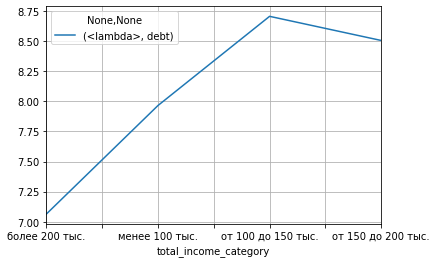

In [16]:
df.pivot_table(index='total_income_category',
               values=['debt'],
               aggfunc=[(lambda x: np.mean(x)*100)]).plot(grid=True)

##### Вывод
- Наибольший процент просрочек в группах с доходом от 100 до 150 тыс (около 8.5%). 
- Возможно заемщики из этих групп берут кредиты бОльшего размера с более высоким платежом. Целесообразно запросить дополнительные данные и проверить взаимосвязь просрочки по кредиту с его размером и величиной ежемесячного платежа.

#### Как разные цели кредита влияют на его возврат в срок?

In [17]:
df.pivot_table(index='purpose_category',
               values=['debt'],
               aggfunc=['count', (lambda x: np.mean(x)*100)])

,count,<lambda>
,debt,debt
purpose_category,,
автомобиль,4279,9.347978
жилье,4437,6.941627
недвижимость,6314,7.475451
образование,3988,9.252758
свадьба,2313,7.911803


#### Вывод
- наибольший процент просрочки для кредитов взятых на автомобиль (9.4%) и образование (9.3%), 
- кредиты связанные с жильем и недвижимостью имеют наименьший процент просрочек, 6.9% и 7.5%, соответственно.

#### Как (в процентах) выплачивают кредит на автомобиль люди с детьми? 

In [18]:
# процент просрочек у заемщиков с детьми и кредитом на автомобиль
v1 = df[(df['purpose_category'] == 'автомобиль') & (df['children'] > 0)]['debt'].mean()
print('Процент просрочек у заемщиков с детьми и кредитом на автомобиль {:.2%}'.format(v1))

# процент просрочек у заемщиков без детей и кредитом на автомобиль
v2 = df[(df['purpose_category'] == 'автомобиль') & (df['children'] == 0)]['debt'].mean()
print('Процент просрочек у заемщиков без детей и кредитом на автомобиль {:.2%}'.format(v2))

Процент просрочек у заемщиков с детьми и кредитом на автомобиль 10.95%
Процент просрочек у заемщиков без детей и кредитом на автомобиль 8.54%


In [19]:
df_auto = df[df['purpose_category'] == 'автомобиль'] 
# более подробное влияние количества детей среди кредитов на автомобиль
df_auto.pivot_table(index='children',
               values=['debt'],
               aggfunc=['count', (lambda x: np.mean(x)*100)])

,count,<lambda>
,debt,debt
children,,
0,2845,8.541301
1,963,10.695742
2,399,12.030075
3,60,8.333333
4,10,10.000000
5,2,0.000000


#### Вывод
- среди кредитов на автомобиль больший процент просрочек имеют заемщики с детьми (10.95%), чем заемщики без детей (8.54%)

In [20]:
df.pivot_table(index='children',
               columns='purpose_category',
               values='debt',
               aggfunc='mean')

purpose_category,автомобиль,жилье,недвижимость,образование,свадьба
children,,,,,
0,0.085413,0.066184,0.068057,0.086677,0.075163
1,0.106957,0.070450,0.089825,0.103926,0.095865
2,0.120301,0.084112,0.085667,0.114144,0.055814
3,0.083333,0.082192,0.072917,0.057971,0.156250
4,0.100000,0.181818,0.100000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000


### Шаг 4. Общий вывод

Самый малый риск просрочек платежа несут заемщики без детей из категорий "вдовец/вдова" и "в разводе" с доходом более 200 тысяч рублей в месяц, берущие кредит на сделку с недвижостью.

Наиболее рискованными являются заемщки имеющие детей, находящиеся в гражданском браке или холостые, с доходом от 100 до 200 тыс, берущие кредит для покупки автомобиля.